In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [26]:
import os
import pandas as pd

print("Current working directory:", os.getcwd())
print("\nFiles in current directory:")
files = os.listdir('.')
for file in files:
    print(f" - {file}")

Current working directory: /content

Files in current directory:
 - .config
 - Turbine Dataset SCADA (1).csv
 - sample_data


In [27]:
from google.colab import files
import os

# Upload files
uploaded = files.upload()

# List CSV files
csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
print("CSV files found:")
for csv in csv_files:
    print(f" - {csv}")

# List turbine or scada related files
turbine_files = [f for f in os.listdir('.') if 'turbine' in f.lower() or 'scada' in f.lower()]
print("\nFiles with 'turbine' or 'scada' in name:")
for file in turbine_files:
    print(f" - {file}")


Saving Turbine Dataset SCADA (1).csv to Turbine Dataset SCADA (1) (1).csv
CSV files found:
 - Turbine Dataset SCADA (1).csv
 - Turbine Dataset SCADA (1) (1).csv

Files with 'turbine' or 'scada' in name:
 - Turbine Dataset SCADA (1).csv
 - Turbine Dataset SCADA (1) (1).csv


In [20]:
  # Check for any CSV files
  csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
  print("CSV files found:")
  for csv in csv_files:
      print(f" - {csv}")

  # Also check for files containing 'turbine' or 'scada'
  turbine_files = [f for f in os.listdir('.') if 'turbine' in f.lower() or 'scada' in f.lower()]
  print("\nFiles with 'turbine' or 'scada' in name:")
  for file in turbine_files:
      print(f" - {file}")

CSV files found:
 - Turbine Dataset SCADA (1).csv

Files with 'turbine' or 'scada' in name:
 - Turbine Dataset SCADA (1).csv


In [24]:
# Try common variations
possible_filenames = [
    'Turbine Dataset SCADA.csv',
    'turbine dataset scada.csv',  # lowercase
    'Turbine_Dataset_SCADA.csv',  # with underscores
    'turbine_data.csv',
    'SCADA.csv',
    'turbine.csv'
]

for filename in possible_filenames:
    if os.path.exists(filename):
        print(f"Found file: {filename}")
        data = pd.read_csv(filename)
        break
else:
    print("No matching CSV file found with common names")

No matching CSV file found with common names


In [6]:
# Robust CSV-finder + loader (works in Colab or locally)
import os
import glob
import pandas as pd

def list_csvs(root='.'):
    # search current dir and one level deeper for csv files
    paths = glob.glob(os.path.join(root, '*.csv')) + glob.glob(os.path.join(root, '*', '*.csv'))
    # deduplicate & sort
    return sorted(set(paths))

def find_likely_turbine_files(paths):
    return [p for p in paths if 'turbine' in p.lower() or 'scada' in p.lower()]

def try_read_csv(path):
    # try common encodings and separators if needed
    read_attempts = [
        {'encoding': 'utf-8', 'sep': None},  # pandas will auto-detect sep
        {'encoding': 'latin1', 'sep': None},
        {'encoding': 'utf-8', 'sep': ','},
        {'encoding': 'latin1', 'sep': ','},
    ]
    for opts in read_attempts:
        try:
            df = pd.read_csv(path, encoding=opts['encoding'], sep=opts['sep'])
            return df
        except Exception as e:
            # keep trying other encodings/seps
            last_exc = e
    # if all attempts failed, raise last exception
    raise last_exc

def parse_datetime_column(df, col_candidates=('Date/Time','date','datetime','timestamp','time','Date Time')):
    # try to find a sensible datetime column and parse it
    for col in df.columns:
        if col in col_candidates or any(k in col.lower() for k in ['date','time','timestamp']):
            # attempt to parse
            for fmt in [None, '%d/%m/%Y %H:%M', '%d-%m-%Y %H:%M', '%Y-%m-%d %H:%M:%S', '%d %m %Y %H:%M']:
                try:
                    # If fmt is None, let pandas infer
                    df[col] = pd.to_datetime(df[col], format=fmt, dayfirst=True, errors='raise', infer_datetime_format=(fmt is None))
                    return col, df
                except Exception:
                    continue
    return None, df

# main logic
is_colab = 'google.colab' in str(getattr(__import__('sys'), 'modules', {}))
print("Running in Colab?:", is_colab)

# If in Colab and you want to browse/upload: uncomment next two lines (user-interaction)
# from google.colab import files
# uploaded = files.upload()  # this opens a file chooser in Colab

# Optionally mount Google Drive (uncomment if in Colab and files live in Drive)
# from google.colab import drive
# drive.mount('/content/drive')

csv_list = list_csvs('.')
print(f"CSV files discovered ({len(csv_list)}):")
for p in csv_list:
    print(" -", p)

candidates = find_likely_turbine_files(csv_list)
if candidates:
    print("\nFiles that look like turbine/SCADA:")
    for p in candidates:
        print(" ->", p)
else:
    print("\nNo obvious turbine/SCADA filenames found. Will try all discovered CSVs.")

# choose the first candidate if available, otherwise first CSV
to_try = candidates if candidates else csv_list

if not to_try:
    raise FileNotFoundError("No CSV files found in working directory or one level deep. Upload or mount your Drive.")

# Attempt to read each candidate until one loads successfully
loaded = False
for path in to_try:
    print(f"\nAttempting to read: {path}")
    try:
        df = try_read_csv(path)
        print(f"Successfully read {path} (shape={df.shape})")
        # try to parse datetime column if present
        dt_col, df = parse_datetime_column(df)
        if dt_col:
            print(f"Parsed datetime column: '{dt_col}'. Setting as index.")
            df.set_index(dt_col, inplace=True)
        else:
            print("No datetime column parsed automatically.")
        # show a quick summary
        print("\nPreview:")
        display(df.head(5))
        print("\nDtypes:")
        print(df.dtypes)
        loaded = True
        loaded_path = path
        break
    except Exception as e:
        print(f"Failed to read {path}: {type(e).__name__}: {e}")

if not loaded:
    raise RuntimeError("Tried all CSVs but couldn't read any. Check encodings, separators or that the file is actually CSV.")
else:
    print(f"\nFinal loaded file: {loaded_path}")
    # expose df for downstream code
    # df is the DataFrame loaded and possibly indexed by datetime


Running in Colab?: True
CSV files discovered (4):
 - ./sample_data/california_housing_test.csv
 - ./sample_data/california_housing_train.csv
 - ./sample_data/mnist_test.csv
 - ./sample_data/mnist_train_small.csv

No obvious turbine/SCADA filenames found. Will try all discovered CSVs.

Attempting to read: ./sample_data/california_housing_test.csv
Successfully read ./sample_data/california_housing_test.csv (shape=(3000, 9))
No datetime column parsed automatically.

Preview:


/tmp/ipython-input-2694830219.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, encoding=opts['encoding'], sep=opts['sep'])


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0



Dtypes:
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
dtype: object

Final loaded file: ./sample_data/california_housing_test.csv


In [7]:
# Robust CSV loader for local/Colab
import os
import glob
import pandas as pd

def list_csvs(root='.'):
    """Search current dir and one level deep for CSV files."""
    paths = glob.glob(os.path.join(root, '*.csv')) + glob.glob(os.path.join(root, '*', '*.csv'))
    return sorted(set(paths))

def find_likely_turbine_files(paths):
    """Return files that likely contain turbine/SCADA data."""
    return [p for p in paths if 'turbine' in p.lower() or 'scada' in p.lower()]

def try_read_csv(path):
    """Try multiple encodings/separators to read a CSV."""
    attempts = [
        {'encoding': 'utf-8', 'sep': None},
        {'encoding': 'latin1', 'sep': None},
        {'encoding': 'utf-8', 'sep': ','},
        {'encoding': 'latin1', 'sep': ','},
        {'encoding': 'utf-8', 'sep': ';'},
        {'encoding': 'latin1', 'sep': ';'},
    ]
    last_exc = None
    for opts in attempts:
        try:
            df = pd.read_csv(path, encoding=opts['encoding'], sep=opts['sep'])
            return df
        except Exception as e:
            last_exc = e
    raise last_exc

def parse_datetime_column(df, col_candidates=('Date/Time','date','datetime','timestamp','time','Date Time')):
    """Automatically detect and parse a datetime column."""
    for col in df.columns:
        if col in col_candidates or any(k in col.lower() for k in ['date','time','timestamp']):
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True, dayfirst=True)
                if df[col].notna().sum() > 0:  # at least some valid dates
                    return col, df
            except Exception:
                continue
    return None, df

def load_turbine_csv(root='.'):
    """Main function to find and load a likely turbine CSV."""
    csv_list = list_csvs(root)
    if not csv_list:
        raise FileNotFoundError("No CSV files found in working directory or one level deep.")

    candidates = find_likely_turbine_files(csv_list)
    to_try = candidates if candidates else csv_list

    for path in to_try:
        try:
            print(f"Trying to read: {path}")
            df = try_read_csv(path)
            dt_col, df = parse_datetime_column(df)
            if dt_col:
                print(f"Detected datetime column: '{dt_col}'")
                df.set_index(dt_col, inplace=True)
            else:
                print("No datetime column detected.")
            print(f"Loaded {path} successfully! Shape: {df.shape}")
            return df, path
        except Exception as e:
            print(f"Failed to read {path}: {type(e).__name__}: {e}")

    raise RuntimeError("Tried all CSVs but couldn't read any.")

# --- USAGE ---

# Detect if running in Colab
is_colab = 'google.colab' in str(getattr(__import__('sys'), 'modules', {}))
if is_colab:
    from google.colab import files
    uploaded = files.upload()  # Optional: allow manual upload in Colab

df, loaded_path = load_turbine_csv('.')
print("\nPreview of loaded data:")
display(df.head())


Saving Turbine Dataset SCADA (1).csv to Turbine Dataset SCADA (1).csv
Trying to read: ./Turbine Dataset SCADA (1).csv


/tmp/ipython-input-4174817637.py:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, encoding=opts['encoding'], sep=opts['sep'])


Detected datetime column: '﻿Date/Time'
Loaded ./Turbine Dataset SCADA (1).csv successfully! Shape: (50530, 4)

Preview of loaded data:


/tmp/ipython-input-4174817637.py:39: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True, dayfirst=True)


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
﻿Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [39]:
# Feature selection
features = ['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
target = 'LV ActivePower (kW)'
# Preview the first 5 rows of your dataset


In [40]:
import numpy as np

# Drop rows with missing values
df = df.dropna()
df.head()

# Define features and target
features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']
target = 'LV ActivePower (kW)'  # or whichever column you want as target

# Function to clip outliers
def clip_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower = df[column].quantile(lower_quantile)
    upper = df[column].quantile(upper_quantile)
    df[column] = np.clip(df[column], lower, upper)

# Apply clipping to features and target
for col in features + [target]:
    clip_outliers(df, col)

print("Preprocessing done. Data ready for analysis.")


Preprocessing done. Data ready for analysis.


In [41]:
df.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
﻿Date/Time,,,,
2018-01-01 00:00:00,0.105464,0.244712,0.115647,259.994904
2018-01-01 00:10:00,0.125922,0.264323,0.144422,268.641113
2018-01-01 00:20:00,0.085020,0.239533,0.108583,272.564789
2018-01-01 00:30:00,0.116453,0.263644,0.143369,271.258087
2018-01-01 00:40:00,0.105631,0.259202,0.136584,265.674286


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)

# Compute regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
RMSE: 0.0708
MAE: 0.0436
R² Score: 0.9617


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Example: convert normalized power into 3 categories
# 0 = Low, 1 = Medium, 2 = High
def categorize(values, n_categories=3):
    return np.digitize(values, bins=np.linspace(0, 1, n_categories+1)) - 1

# Categorize predictions and true values
y_test_cat = categorize(y_test)
y_pred_cat = categorize(y_pred)

# Compute classification metrics
accuracy = accuracy_score(y_test_cat, y_pred_cat)
precision = precision_score(y_test_cat, y_pred_cat, average='weighted')
recall = recall_score(y_test_cat, y_pred_cat, average='weighted')
f1 = f1_score(y_test_cat, y_pred_cat, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8488
Precision: 0.9031
Recall: 0.8488
F1 Score: 0.8699


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
from sklearn.preprocessing import MinMaxScaler

# Define features and target
features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']
target = 'LV ActivePower (kW)'  # or whichever column you want as target

# Initialize scaler
scaler = MinMaxScaler()

# Apply Min-Max normalization to features + target
df[features + [target]] = scaler.fit_transform(df[features + [target]])

# Optional: preview normalized data
df.head()


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
﻿Date/Time,,,,
2018-01-01 00:00:00,0.105464,0.244712,0.115647,259.994904
2018-01-01 00:10:00,0.125922,0.264323,0.144422,268.641113
2018-01-01 00:20:00,0.085020,0.239533,0.108583,272.564789
2018-01-01 00:30:00,0.116453,0.263644,0.143369,271.258087
2018-01-01 00:40:00,0.105631,0.259202,0.136584,265.674286


In [15]:
import numpy as np

# Convert to supervised learning problem
def create_sequences(data_array, target_array, seq_length):
    xs, ys = [], []
    for i in range(len(data_array) - seq_length):
        x = data_array[i:i+seq_length]
        y = target_array[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Example sequence length (e.g., 24 hours)
seq_length = 24

# Use df instead of data
X, y = create_sequences(df[features].values, df[target].values, seq_length)

print("Sequences created:")
print("X shape:", X.shape)
print("y shape:", y.shape)


Sequences created:
X shape: (50506, 24, 3)
y shape: (50506,)


In [18]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from sklearn.model_selection import train_test_split

# Train-test split (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train-test split done:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Train-test split done:
X_train shape: (40404, 24, 3)
X_test shape: (10102, 24, 3)
y_train shape: (40404,)
y_test shape: (10102,)


In [22]:
import tensorflow.keras.layers
import tensorflow.keras.models

# Model architecture with dropout and batch normalization
inputs = Input(shape=(seq_length, len(features)))
x = Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
x = BatchNormalization()(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = GRU(50, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(25, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 23, 64)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 23, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 23, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 23, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1150)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │        28,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,805 (264.86 KB)

 Trainable params: 67,677 (264.36 KB)

 Non-trainable params: 128 (512.00 B)

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Assuming `inputs` and `outputs` are already defined
model = Model(inputs, outputs)

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 23, 64)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 23, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 23, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 23, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1150)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │        28,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,805 (264.86 KB)

 Trainable params: 67,677 (264.36 KB)

 Non-trainable params: 128 (512.00 B)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0353 - mae: 0.1240 - val_loss: 0.0084 - val_mae: 0.0683 - learning_rate: 0.0010
Epoch 2/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0150 - mae: 0.0855 - val_loss: 0.0170 - val_mae: 0.0905 - learning_rate: 0.0010
Epoch 3/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0126 - mae: 0.0799 - val_loss: 0.0065 - val_mae: 0.0522 - learning_rate: 0.0010
Epoch 4/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0106 - mae: 0.0739 - val_loss: 0.0074 - val_mae: 0.0592 - learning_rate: 0.0010
Epoch 5/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0102 - mae: 0.0727 - val_loss: 0.0064 - val_mae: 0.0545 - learning_rate: 0.0010
Epoch 6/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0098 - mae: 0.0714 - val_loss: 0.0051 - val_mae: 0.0476 - learning_rate: 0.0010
Epoch 7/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0096 - mae: 0.0711 - val_loss: 0.0057 - val_mae: 0.0476 - 

In [28]:
# Model evaluation
predicted = model.predict(X_test)

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [32]:
# Checking for small actual values
small_value_threshold = 0.01
small_values = np.sum(y_test < small_value_threshold)
total_values = len(y_test)
print(f'Number of small actual values (< {small_value_threshold}): {small_values} out of {total_values}')

# Handling negative predictions by setting them to zero
predicted = np.maximum(predicted, 0)

Number of small actual values (< 0.01): 2406 out of 10102


In [33]:
# Evaluation metrics
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
msle = mean_squared_log_error(y_test, predicted)

In [34]:
# Output the results
print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Squared Logarithmic Error (MSLE): {msle}")

Model Evaluation Metrics:
Mean Squared Error (MSE): 0.005009516537638626
Root Mean Squared Error (RMSE): 0.07077793821268479
Mean Absolute Error (MAE): 0.04355760606374756
R-squared (R²): 0.9616635004832562
Mean Squared Logarithmic Error (MSLE): 0.0023654051936743484


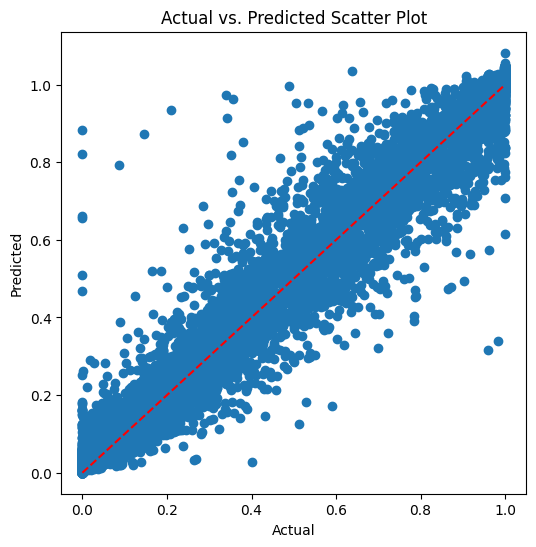

In [35]:
# Visualizing results
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predicted)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Scatter Plot')
plt.show()

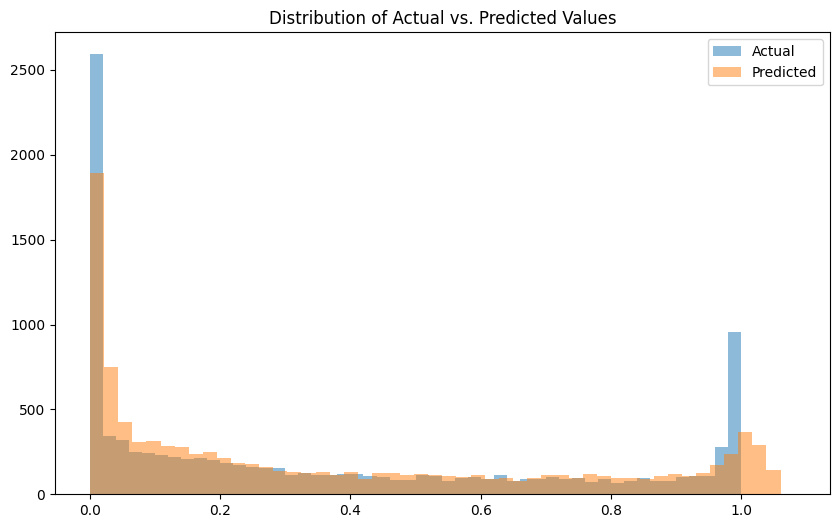

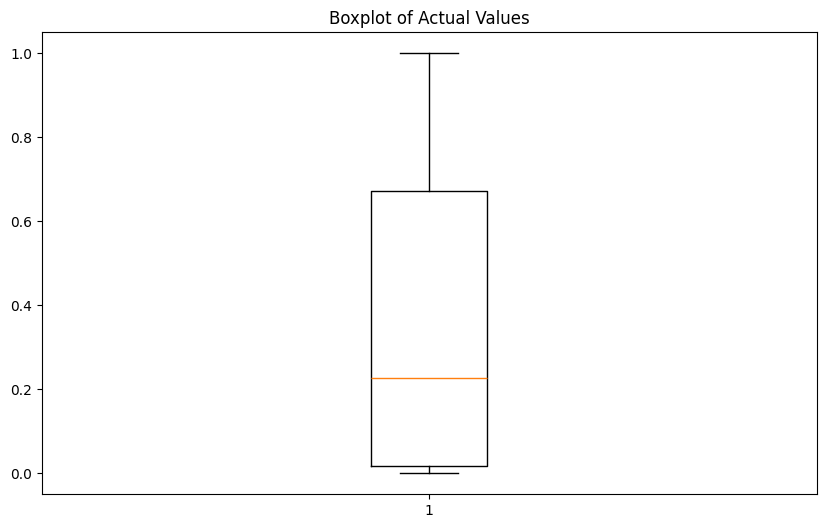

In [36]:
# Checking the distribution of actual and predicted values
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=50, alpha=0.5, label='Actual')
plt.hist(predicted, bins=50, alpha=0.5, label='Predicted')
plt.legend()
plt.title('Distribution of Actual vs. Predicted Values')
plt.show()

# Checking for outliers in the actual values
plt.figure(figsize=(10, 6))
plt.boxplot(y_test)
plt.title('Boxplot of Actual Values')
plt.show()

Negative values in inverse transformed y_test: False
Negative values in inverse transformed predicted: False


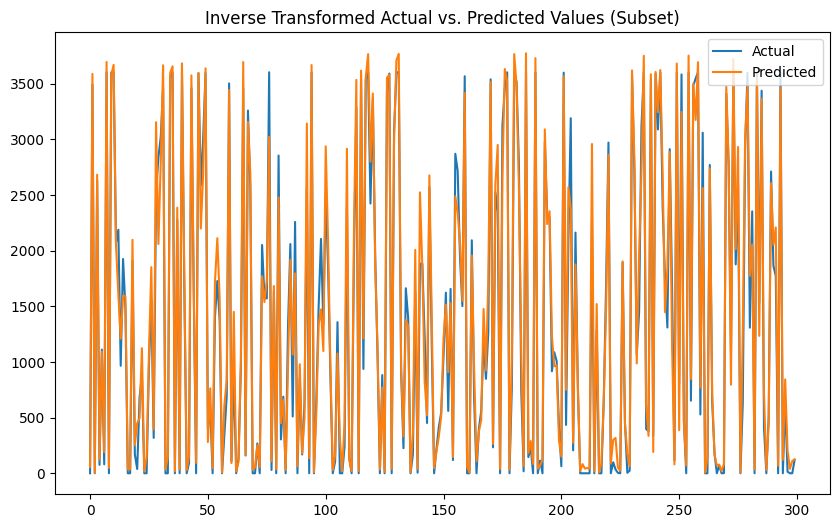

In [37]:
# Inverse transform the target variable if it was scaled
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)], axis=1))[:, -1]
predicted_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(predicted), len(features))), predicted.reshape(-1, 1)], axis=1))[:, -1]

# Checking for negative values in the inverse transformed predictions
print(f'Negative values in inverse transformed y_test: {np.any(y_test_inv < 0)}')
print(f'Negative values in inverse transformed predicted: {np.any(predicted_inv < 0)}')

# Plotting the inverse transformed actual vs. predicted values (subset for clarity)
subset_size = 300  # Adjust this to plot a manageable subset for clarity
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv[:subset_size], label='Actual')
plt.plot(predicted_inv[:subset_size], label='Predicted')
plt.legend()
plt.title('Inverse Transformed Actual vs. Predicted Values (Subset)')
plt.show()

In [38]:
model.save('hybrid_model.h5')